In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention,concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, Softmax, Concatenate
import tensorflow as tf
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [23]:
data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
data.set_index('Ngay', inplace=True)
print(data.head(9)) 

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
01/01/2008        120        498.815         259.499               0.0   
02/01/2008        117        470.866         518.755               0.0   
03/01/2008        139        423.816         615.242               0.0   
04/01/2008        166        496.882         902.982               0.0   
05/01/2008        179        501.232        1072.970               0.0   
06/01/2008        199        346.358         393.919               0.0   
07/01/2008        190        421.766        1109.965               0.0   
08/01/2008        178        423.221        1037.933               0.0   
09/01/2008        200        538.175        1033.090               0.0   

            chayMayTuyenQuan  nuocVeThacBa  chayMayThacBa  
Ngay                                                       
01/01/2008               0.0        23.230         90.200  
02/01

In [24]:
# Chuẩn hóa dữ liệu để đưa về khoảng [0, 1] để dễ xử lý khi đưa vào mô hình
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [25]:
sequence_length = 1 # Sử dụng số ngày trước để dự báo ngày tiếp theo
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i])

X, y = np.array(X), np.array(y)

In [26]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [27]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [28]:
class GlobalSelfAttention(Layer):
    def __init__(self, d_model, num_heads):
        super(GlobalSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)

        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v):
        """Calculate the attention weights."""
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        # Scale matmul_qk
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Apply softmax to get the attention weights
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)
        return output, attention_weights

    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len, depth)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len, d_model)

        return output, attention_weights


In [29]:
# 2. Xây dựng mô hình với LSTM và Attention
input_layer = Input(shape=(X.shape[1], X.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(input_layer)

In [30]:
# Áp dụng lớp GlobalSelfAttention
global_attention_layer = GlobalSelfAttention(d_model=64, num_heads=4)
attention_output, attention_weights = global_attention_layer(lstm_out, lstm_out, lstm_out)
concat_output = Concatenate()([lstm_out, attention_output])

In [31]:
# Lớp đầu ra
output_layer = Dense(7)(concat_output[:, -1, :])

In [32]:
# Khởi tạo và biên dịch mô hình
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1, 7)]               0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 1, 64)                18432     ['input_2[0][0]']             
                                                                                                  
 global_self_attention_1 (G  ((None, None, 64),           16640     ['lstm_1[0][0]',              
 lobalSelfAttention)          (None, 4, None, None))                 'lstm_1[0][0]',              
                                                                     'lstm_1[0][0]']              
                                                                                            

In [33]:
# 3. Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
64/64 [==============================] - 5s 24ms/step - loss: 0.0239 - val_loss: 0.0106
Epoch 2/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 3/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0062
Epoch 4/50
64/64 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0061
Epoch 5/50
64/64 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 6/50
64/64 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 0.0058
Epoch 7/50
64/64 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0058
Epoch 8/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0057
Epoch 9/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 10/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 11/50
64/64 

In [34]:
def nse(y_true, y_pred):
    return 1 - sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2)

In [35]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R² (R-squared):", r2)

# Tính NSE
nse_value = nse(y_test.flatten(), y_pred.flatten())
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

# Tính MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

16/16 [==============================] - 1s 3ms/step
R² (R-squared): 0.7894274670560355
Nash-Sutcliffe Efficiency (NSE): 0.8657514391708652
Mean Absolute Error (MAE): 0.04343513266035644
Root Mean Squared Error (RMSE): 0.07471915207776597


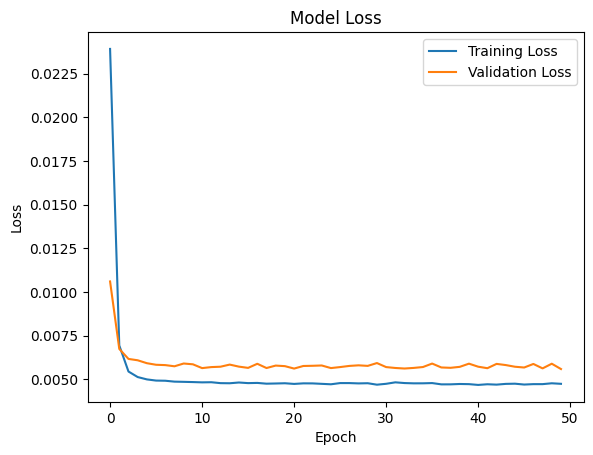

In [36]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
# 5. Vẽ đồ thị dự báo so sánh với thực tế cho từng mực nước
data_test = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2_1.csv') 
data_test['Ngay'] = pd.to_datetime(data_test['Ngay'], format='%d/%m/%Y')
data_test.set_index('Ngay', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_test)

In [38]:
# Chuẩn hóa dữ liệu test bằng scaler đã huấn luyện
data_test_scaled = scaler.transform(data_test)
X_new,Y_new = [],[]
for i in range(sequence_length, len(data_test_scaled)):
    X_new.append(data_test_scaled[i-sequence_length:i])
    Y_new.append(data_test_scaled[i])
X_new = np.array(X_new)
print(len(X_new))
y_new = np.array(Y_new)

737


In [39]:
predictions_new = model.predict(X_new)
predictions_new_original = scaler.inverse_transform(predictions_new )[:,0]
y_test_new_original = scaler.inverse_transform(y_new)[:,0]

24/24 [==============================] - 1s 2ms/step


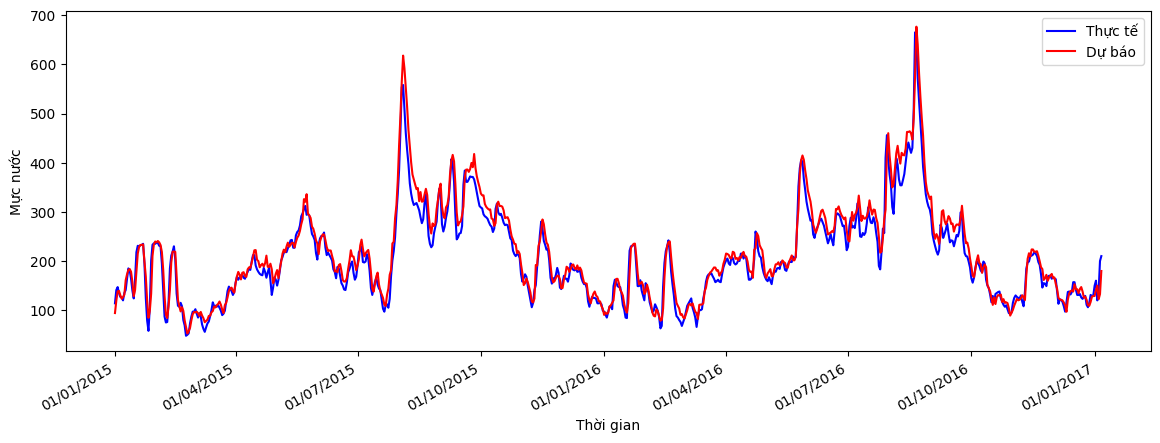

In [40]:
# Đảm bảo các mảng có cùng kích thước
import matplotlib.dates as mdates 
min_length = min(len(data_test.index), len(y_test_new_original), len(predictions_new_original))

# Cắt ngắn mảng theo độ dài nhỏ nhất
dates = data_test.index[:min_length]
y_test_new_original = y_test_new_original[:min_length]
predictions_new_original = predictions_new_original[:min_length]

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_new_original, label='Thực tế', color='blue')
plt.plot(dates, predictions_new_original, label='Dự báo', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước')

# Định dạng ngày tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


In [41]:
# Tạo mảng ngày bắt đầu từ chỉ số sequence_length của new_data
dates = data_test.index[sequence_length:]

# Đảm bảo số lượng phần tử của dự báo và thực tế khớp với số lượng ngày
min_length = min(len(dates), len(predictions_new_original), len(y_test_new_original))

# Cắt ngắn các mảng để khớp số phần tử nếu cần
dates = dates[:min_length]
predictions_new_original = predictions_new_original[:min_length]
y_test_new_original = y_test_new_original[:min_length]

predictions_new_original= np.round(predictions_new_original, 3)
# Tạo DataFrame với ngày, thực tế và dự báo
df_mucNuocHN = pd.DataFrame({
    'Ngay': dates,
    'ThucTe': y_test_new_original,
    'DuBao': predictions_new_original
})

# Đặt cột 'Ngay' làm chỉ mục
df_mucNuocHN.set_index('Ngay', inplace=True)

# Đặt tên đa cấp cho các cột với nhóm 'mucNuocHaNoi'
df_mucNuocHN.columns = pd.MultiIndex.from_product([['mucNuocHaNoi'], ['ThucTe', 'DuBao']])

# Hiển thị DataFrame
print(df_mucNuocHN)


           mucNuocHaNoi            
                 ThucTe       DuBao
Ngay                               
2015-01-02        114.0   94.186996
2015-01-03        141.0  119.242996
2015-01-04        147.0  138.276993
2015-01-05        135.0  139.244995
2015-01-06        127.0  130.345001
...                 ...         ...
2017-01-03        160.0  141.367996
2017-01-04        120.0  149.886993
2017-01-05        140.0  122.367996
2017-01-06        200.0  132.725006
2017-01-07        210.0  179.705994

[737 rows x 2 columns]
